<a href="https://colab.research.google.com/github/oscarserc/VISION_por_COMPUTADORA/blob/main/CV_Practica_2a_Localizacion_de_objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [ ]:

train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [ ]:
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


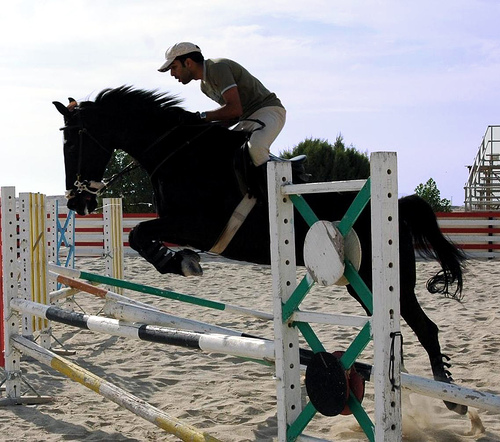

In [ ]:

# HEMOS CREADO LA BASE DE DATOS DE 'TRAIN'
# ========================================
# En cada registro vienen empaquetados 2 componentes
#  · UNA IMAGEN
#  · UNA 'ETIQUETA' (que en realidad es un diccionario con muchos componentes, 
#    como: nombre de archivo, tamaño, objetos que contiene, coordenadas, etc)

img, label = train[0]
img


In [ ]:
label

{'annotation': {'filename': '2008_000008.jpg',
  'folder': 'VOC2012',
  'object': [{'bndbox': {'xmax': '471',
     'xmin': '53',
     'ymax': '420',
     'ymin': '87'},
    'difficult': '0',
    'name': 'horse',
    'occluded': '1',
    'pose': 'Left',
    'truncated': '0'},
   {'bndbox': {'xmax': '289', 'xmin': '158', 'ymax': '167', 'ymin': '44'},
    'difficult': '0',
    'name': 'person',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '1'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '442', 'width': '500'},
  'source': {'annotation': 'PASCAL VOC2008',
   'database': 'The VOC2008 Database',
   'image': 'flickr'}}}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  # EXTRAEMOS LOS DOS COMPONENTES DE CADA REGISTRO DE LA BASE DE DATOS
  # ------------------------------------------------------------------
  img, label = train[ix]

  # HACEMOS UN TRATAMIENTO DE LOS DOS COMPONENTES QUE HAY EN CADA REGISTRO
  # ----------------------------------------------------------------------
  # · Convertimos en un array de numpy la IMAGEN
  img_np = np.array(img)
  # · Extraemos del diccionario 'LABEL' el componente: OBJECT, que es a su vez otro
  #   diccionario. --> Contiene una lista de diccionarios, cada uno de ellos
  #   con las características de uno de los objetos que aparezca en la imagen 
  anns   = label['annotation']['object']
  
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  coordenadas_bbs = [ann['bndbox'] for ann in anns]
  coordenadas_bbs = np.array([[int(bb['xmin']), int(bb['ymin']),  int(bb['xmax']) - int(bb['xmin']), int(bb['ymax']) - int(bb['ymin'])] for bb in coordenadas_bbs])
  anns = (labels, coordenadas_bbs)

  return img_np, anns


def plot_anns(img, anns, ax=None, bg=-1):
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      # TRATAMOS SEPARADAMENTE LAS COORDENADAS DE CADA OBJETO DE LA IMAGEN
      x, y, w, h = bb
      rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x,y - 10, classes[lab], {'color':'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)



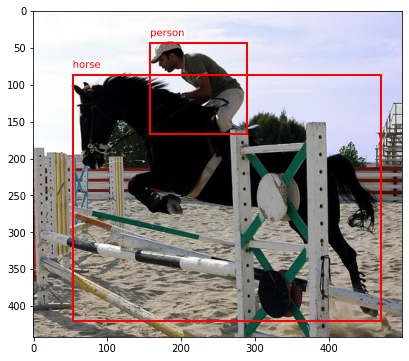

In [ ]:
img_np, anotaciones = get_sample(0)
plot_anns(img_np, anotaciones)
plt.show()

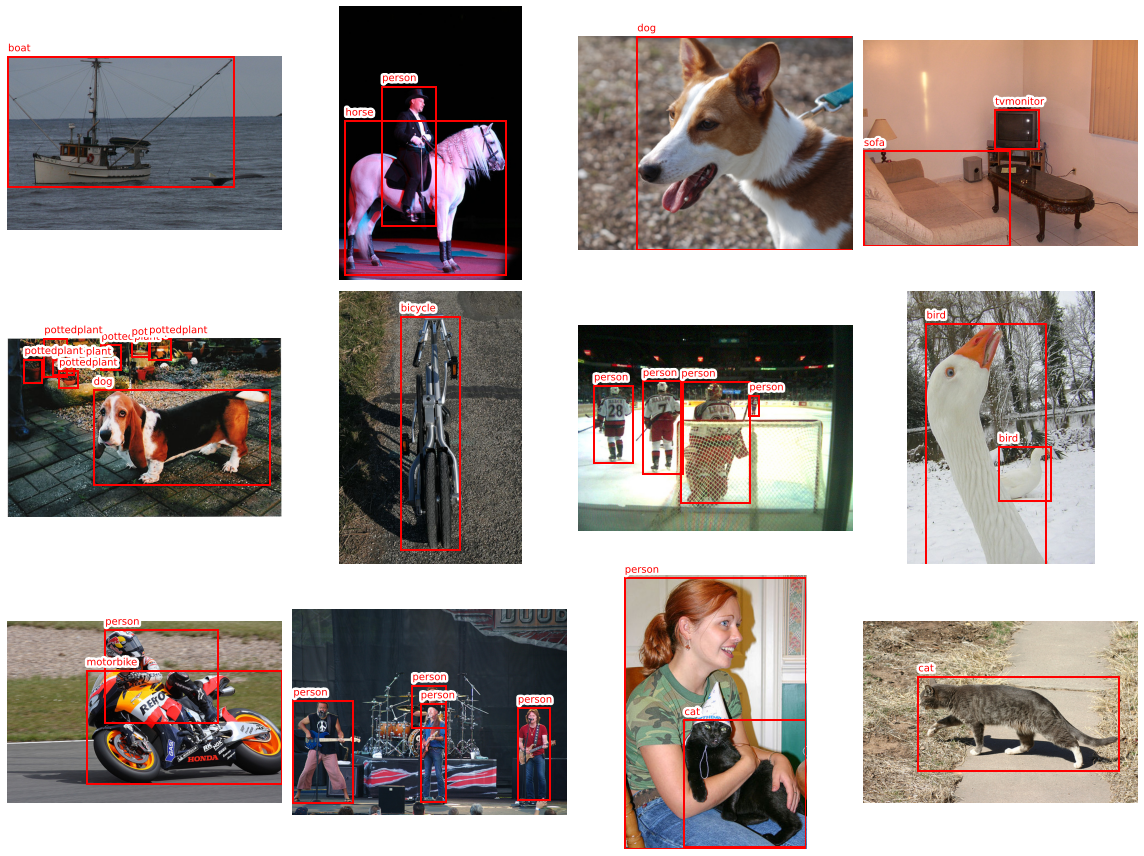

In [ ]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
  for _c in range(c):
    ax = plt.subplot(r, c, _r*c + _c + 1)
    ix = random.randint(0, len(train) -1)
    img_np, anns = get_sample(ix)
    plot_anns(img_np, anns, ax)
    plt.axis('off')
plt.tight_layout()
plt.show()    

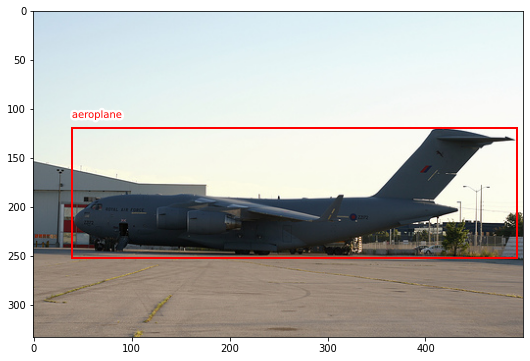

In [ ]:
img_np, anns = get_sample(4445)
plot_anns(img_np, anns)
plt.show()

## **Ahora pasamos a la construcción del MODELO. Será basicamente una RED CONVOLUCIONAL a la que se le añade una capa para llevar a cabo una regresión (a los valores que forman la caja)**

In [ ]:

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
  return torch.nn.Sequential(
      torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(pk, stride=ps)
  )

def block2(c_in, c_out):
  return torch.nn.Sequential(
      torch.nn.Linear(c_in, c_out),
      torch.nn.ReLU()
  )  

class Model(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=4):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16,32)
    self.conv4 = block(32,64)
    self.fc1 = block2(64*6*6, 100)
    self.fc2 = torch.nn.Linear(100, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x



In [ ]:
model = Model()
salidas = model(torch.randn(64, 3, 100, 100))
salidas.shape

torch.Size([64, 4])

In [ ]:

# COMO LAS DIMENSIONES CON LAS QUE TRABAJA LA RED CONVOLUCIONAL
# SON MUY ESPECÍFICAS, TENEMOS QUE REALIZAR UNA TRANSFORMACIÓN SOBRE LAS IMÁGENES
# (y también sobre las coordenadas de las cajas)
# -------------------------------------------------------------------------------

import albumentations as A

def get_aug(aug, min_area=0., min_visibility=0.):
  return A.Compose(aug, bbox_params = {'format': 'coco',
                                       'min_area': min_area,
                                       'min_visibility': min_visibility,
                                       'label_fields': ['labels']
                                       }
                   )

transformacion = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented   = transformacion(**{'image': img_np, 'bboxes': bbs, 'labels': labels})

img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs


((100, 100, 3), [[7.8, 35.73573573573574, 90.8, 39.93993993993994]])

## **Para hacer una regresión con las COORDENADAS de los OBJETOS, primero tenemos que normalizarlas, ya que toman valores muy altos y ésto daría problemas en el entrenamiento de la red neuronal**.

In [ ]:

def norm(bb, shape):
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  h, w = shape  
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])


In [ ]:
bb = bbs[0]
bb

[7.8, 35.73573573573574, 90.8, 39.93993993993994]

In [ ]:
bb_norm = norm(bb, img.shape[:2])
bb_norm

array([0.078     , 0.35735736, 0.908     , 0.3993994 ])

In [ ]:
img.shape

(100, 100, 3)

In [ ]:
bb_unnorm = unnorm(bb_norm, img.shape[:2])
bb_unnorm

array([ 7.8       , 35.73573574, 90.8       , 39.93993994])

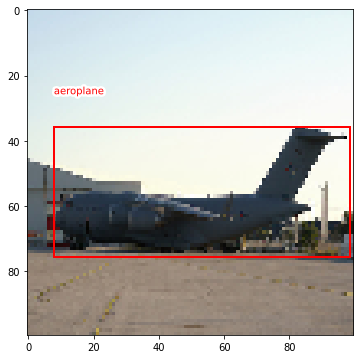

In [ ]:
plot_anns(img, (labels, bbs))
plt.show()

In [ ]:

# PROCEDEMOS AL ENTRENAMIENTO
# ===========================

def fit(model, X, y, epochs=1, lr=1e-3):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss()

  for epoch in range(1, epochs+1):
    model.train()
    train_loss = []
    X, y = X.to(device), y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    print(f'Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}')


In [ ]:

# Vamos a utilizar 1 sóla imagen para que vaya haciendo regresiones
# a ver si logra centrar la caja en el objeto (paramos en 30 epochs)
# ------------------------------------------------------------------

model = Model()
img_tensor = torch.FloatTensor(img/255.).permute(2,0,1).unsqueeze(0)
bb_tensor  = torch.FloatTensor(bb_norm).unsqueeze(0)
fit(model, img_tensor, bb_tensor, epochs=30) 


Epoch 1/30 loss 0.39131
Epoch 2/30 loss 0.36081
Epoch 3/30 loss 0.34301
Epoch 4/30 loss 0.31209
Epoch 5/30 loss 0.26000
Epoch 6/30 loss 0.18204
Epoch 7/30 loss 0.11495
Epoch 8/30 loss 0.12461
Epoch 9/30 loss 0.19027
Epoch 10/30 loss 0.15986
Epoch 11/30 loss 0.08411
Epoch 12/30 loss 0.06516
Epoch 13/30 loss 0.08515
Epoch 14/30 loss 0.11324
Epoch 15/30 loss 0.13029
Epoch 16/30 loss 0.12962
Epoch 17/30 loss 0.11483
Epoch 18/30 loss 0.09224
Epoch 19/30 loss 0.05477
Epoch 20/30 loss 0.02681
Epoch 21/30 loss 0.06051
Epoch 22/30 loss 0.09298
Epoch 23/30 loss 0.09121
Epoch 24/30 loss 0.06764
Epoch 25/30 loss 0.02566
Epoch 26/30 loss 0.02632
Epoch 27/30 loss 0.05126
Epoch 28/30 loss 0.06150
Epoch 29/30 loss 0.05882
Epoch 30/30 loss 0.04550


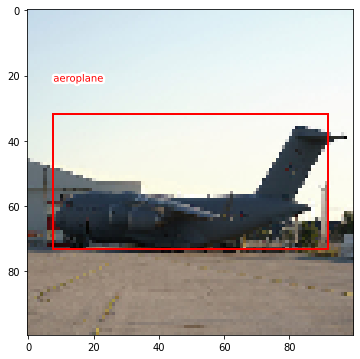

In [ ]:

model.eval()
pred_bb_norm = model(img_tensor.to(device))[0].cpu().detach().numpy()
pred_bb      = unnorm(pred_bb_norm, img.shape[:2])
plot_anns(img, (anns[0], [pred_bb]))
plt.show()
